# Exploratory Analysis

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from src import utils

%load_ext autoreload
%autoreload 2

# Read Data

In [2]:

config = utils.get_config('config/config.ini')
raw_load_data_path = utils.get_full_path(config['data_paths']['raw_load_data'])
raw_temp_data_path = utils.get_full_path(config['data_paths']['raw_temp_data'])

raw_load_data = pd.read_csv(raw_load_data_path, parse_dates=[0])
raw_temp_data = pd.read_csv(raw_temp_data_path, parse_dates=[0])

print(raw_load_data.head())
print(raw_temp_data.head())

        Date  Hour     Load
0 2005-01-01     1  156.545
1 2005-01-01     2  147.924
2 2005-01-01     3  141.037
3 2005-01-01     4  139.125
4 2005-01-01     5  140.482
        Date  Hour  Station ID  Temperature
0 2005-01-01     1           1           43
1 2005-01-01     2           1           41
2 2005-01-01     3           1           40
3 2005-01-01     4           1           39
4 2005-01-01     5           1           38


## preliminary preprocessing

In [3]:
raw_load_data.columns = ['date', 'hr', 'load']
raw_temp_data.columns = ['date', 'hr', 'station_id', 'temperature']



raw_load_data['datetime'] = raw_load_data.date + pd.to_timedelta(raw_load_data.hr, unit='h')

# Exploration

## knowledge from the data
Based on intuition, we could explore various trajectories which might be relevant to electriity demand. This may include factors based on time of the day, day of the week and month of the year. However, another way might be to leverage the power of unsupervised techniques in discerning patterns from the data with limited assumptions.

In particular, we would use the PCA in order to decompose the daily electricity usage patterns. To do this, the data would be transformed such that each 24 hour day is treated as a sample. The PCA might then be able to extract daily usage modes through its first few principal components

<Axes: xlabel='datetime'>

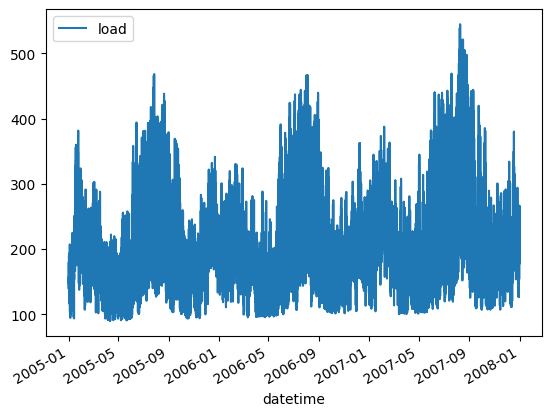

In [4]:

raw_load_data.plot(x='datetime', y='load')

/tmp/ipykernel_4128/688738188.py:9: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  raw_load_data.set_index('datetime').resample(v)['load'].sum().plot(ax=ax)


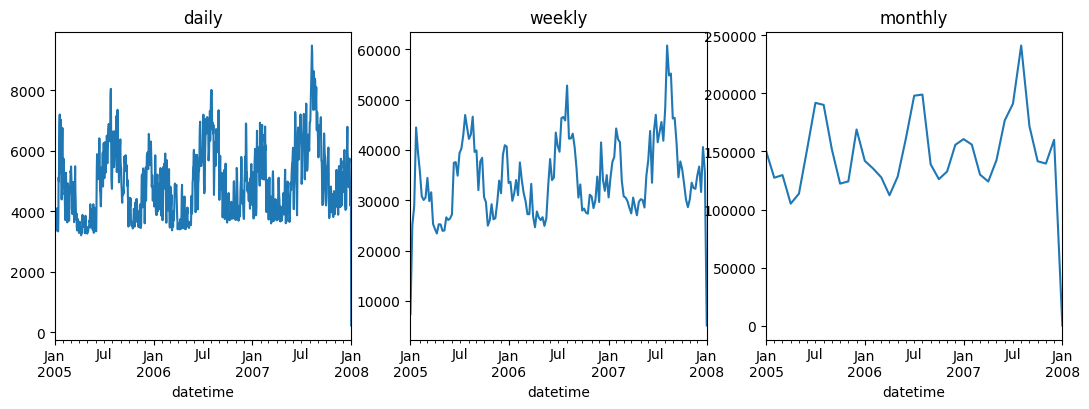

In [5]:
resample_dict = {'daily':'D', 'weekly':'W', 'monthly':'M'}

fig, axs = plt.subplots(ncols=3, figsize=(13,4))
axs = axs.flatten()
for i, (k, v) in enumerate(resample_dict.items()):

    ax = axs[i]

    raw_load_data.set_index('datetime').resample(v)['load'].sum().plot(ax=ax)
    ax.set_title(k)

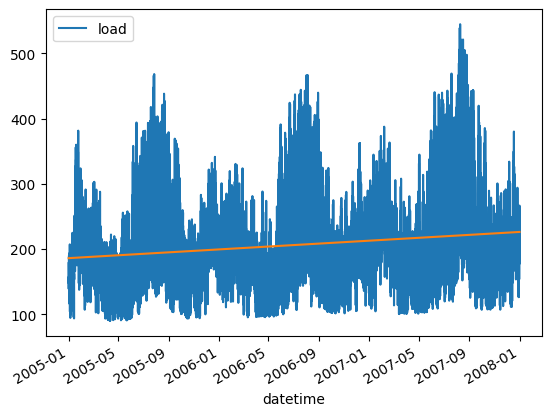

In [6]:
from sklearn.linear_model import LinearRegression

lin_model = LinearRegression()

X = np.arange(len(raw_load_data)).reshape(-1, 1)
y = raw_load_data[['load']]

lin_model.fit(X, y)

y_hat = lin_model.predict(X)

fig, ax = plt.subplots()

raw_load_data.plot(x='datetime', y='load', ax=ax)

ax.plot(raw_load_data.datetime, y_hat)

Note: daylight saving causes multiple hour 2 on one day and no hour 2 on another day within a year

In [7]:
pivoted_load_data = raw_load_data.pivot_table(values='load', index='date', columns='hr')

from sklearn.decomposition import PCA
X = pivoted_load_data.loc[:, 3:].values  # from 3 because some hours are null for hour 2


pca = PCA().fit(X)
ftv = pca.explained_variance_[0:] / np.sum(pca.explained_variance_[0:])

X_pca = pca.transform(X)
X_mean = np.mean(X, axis=0)

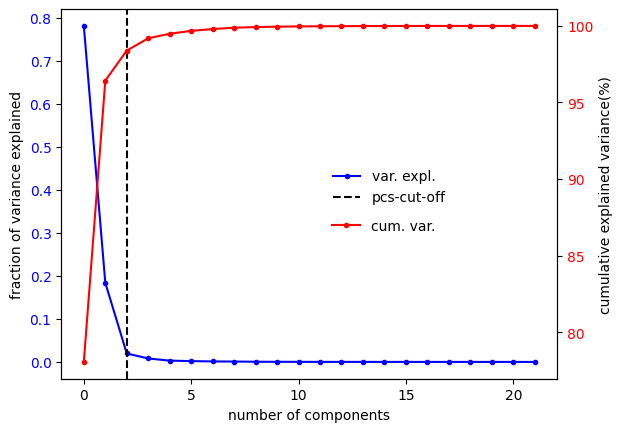

In [8]:
fig, ax = plt.subplots()
ax2 = ax.twinx()
#ax2.plot(np.cumsum(pca.explained_variance_ratio_*100.0), '-.', c='r',  label='cum. var.')
ax2.plot(np.cumsum(ftv*100.0), '.-', c='r',  label='cum. var.')
ax.set_xlabel('number of components')
ax2.set_ylabel('cumulative explained variance(%)');
ax2.ticklabel_format(useOffset=False)


ax.tick_params(axis='y', labelcolor='b')
ax2.tick_params(axis='y', labelcolor='r')

ax.plot(np.arange(X.shape[1])[0:], pca.explained_variance_ratio_[0:], '.-', c='b', label='var. expl.')

ax.set_ylabel('fraction of variance explained')

ax.axvline(x=2,  ls='--', c='black', label='pcs-cut-off')

ax.legend(bbox_to_anchor=(0.8,0.6), frameon=False)
ax2.legend(bbox_to_anchor=(0.78,0.465), frameon=False)
ax.grid(False)
ax2.grid(False)

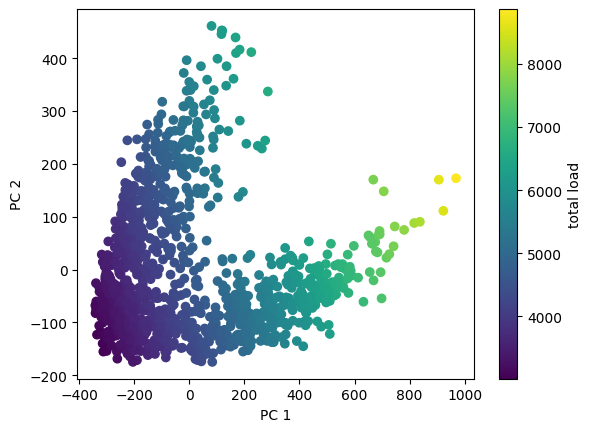

In [9]:
X_pca = PCA(2).fit_transform(X)

total_load = X.sum(axis=1)

plt.scatter(X_pca[:, 0], X_pca[:, 1], c=total_load, cmap='viridis')
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.colorbar(label='total load')


/tmp/ipykernel_4128/1104920577.py:8: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  plt.scatter(X_pca[:, 0], X_pca[:, 1], alpha=0.3, c=cluster_label, cmap=plt.cm.get_cmap('jet', n_components));


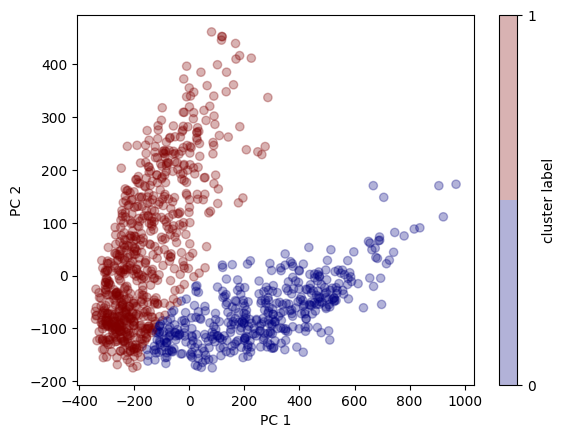

In [11]:
from sklearn.mixture import GaussianMixture as GM

n_components=2
gmm = GM(n_components=n_components, covariance_type='full', random_state=0)

gmm.fit(X_pca)
cluster_label = gmm.predict(X_pca)
plt.scatter(X_pca[:, 0], X_pca[:, 1], alpha=0.3, c=cluster_label, cmap=plt.cm.get_cmap('jet', n_components));
plt.xlabel('PC 1')
plt.ylabel('PC 2')
cb = plt.colorbar(ticks=range(n_components), label='cluster label')
# plt.clim(-0.5, 1.5);


        date  hr     load            datetime  cluster
0 2005-01-01   1  156.545 2005-01-01 01:00:00        1
1 2005-01-01   2  147.924 2005-01-01 02:00:00        1
2 2005-01-01   3  141.037 2005-01-01 03:00:00        1
3 2005-01-01   4  139.125 2005-01-01 04:00:00        1
4 2005-01-01   5  140.482 2005-01-01 05:00:00        1
                                          date    hr        load  \
cluster datetime                                                   
0       00:00:00 2006-08-24 10:18:06.792452864  24.0  214.153479   
        01:00:00 2006-08-24 10:18:06.792452864   1.0  179.335738   
        02:00:00 2006-08-24 10:18:06.792452864   2.0  159.394795   
        03:00:00 2006-08-24 10:18:06.792452864   3.0  147.191104   
        04:00:00 2006-08-24 10:18:06.792452864   4.0  139.822925   

                                      datetime  
cluster datetime                                
0       00:00:00 2006-08-25 10:18:06.792452864  
        01:00:00 2006-08-24 11:18:06.792452864

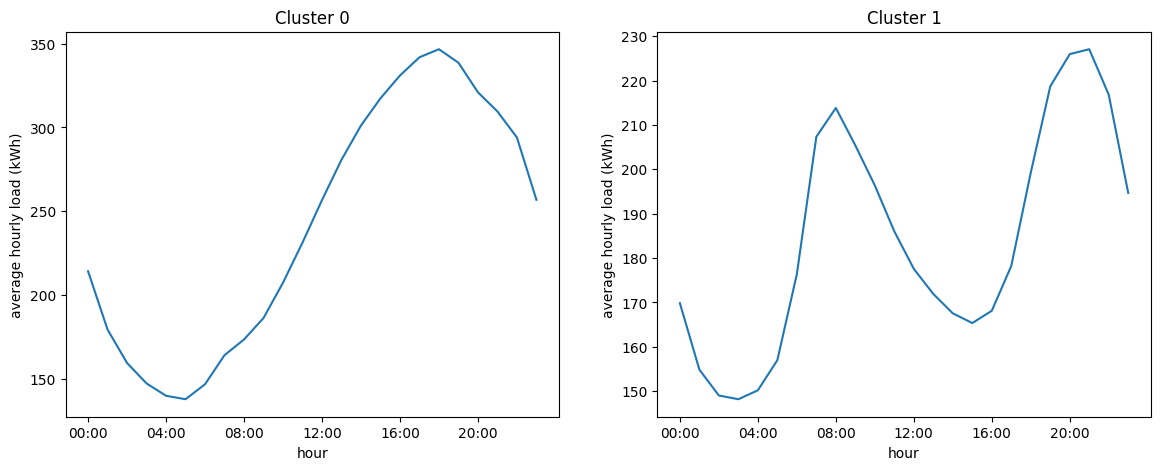

In [14]:
pivoted_load_data['cluster'] = cluster_label

temp_df = raw_load_data.join(pivoted_load_data['cluster'], on='date')
print(temp_df.head())
temp_df = temp_df.groupby(['cluster', temp_df.datetime.dt.time]).mean()
print(temp_df.head())
fig, ax = plt.subplots(1, n_components, figsize=(14, 5))
hourly_ticks = 4 * 60 * 60 * np.arange(6)

for i in range(n_components):
    temp_df.loc[i]['load'].plot(ax=ax[i], xticks=hourly_ticks)
    ax[i].set_title(f'Cluster {i}')
    ax[i].set_ylabel('average hourly load (kWh)')
    ax[i].set_xlabel('hour')

In [192]:
pivoted_load_data.head()

hr,1,2,3,4,5,6,7,8,9,10,...,16,17,18,19,20,21,22,23,24,cluster
date,,,,,,,,,,,,,,,,,,,,,
2005-01-01,156.545,147.924,141.037,139.125,140.482,144.726,151.682,160.795,176.263,179.873,...,147.001,151.095,173.793,190.031,185.218,177.967,169.502,155.938,139.258,1
2005-01-02,125.346,118.416,116.780,118.143,122.795,129.928,143.200,163.824,189.415,188.124,...,140.381,144.440,172.000,193.696,193.642,187.023,175.177,155.832,135.549,1
2005-01-03,122.339,118.007,118.395,121.960,130.080,149.409,175.835,182.662,178.082,173.236,...,139.375,147.925,176.941,206.153,207.321,198.564,181.833,156.097,130.021,1
2005-01-04,112.989,106.235,104.199,104.420,110.352,130.518,165.650,170.033,153.113,144.468,...,134.757,141.920,169.484,198.253,199.114,192.287,174.515,149.467,121.726,1
2005-01-05,104.565,96.840,94.634,95.623,102.136,124.298,163.341,166.844,149.561,140.662,...,129.564,139.329,169.886,197.035,195.727,189.599,176.341,150.423,123.757,1


/tmp/ipykernel_26600/3249237343.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap=plt.cm.get_cmap('jet', 12), alpha=0.4, s=6)


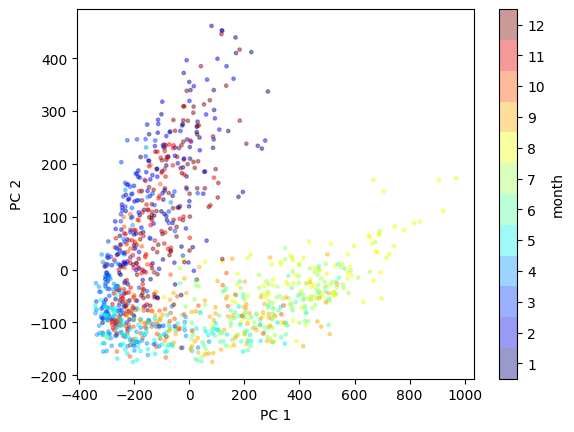

In [245]:
month_of_year = pivoted_load_data.index.month
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=month_of_year,
            cmap=plt.cm.get_cmap('jet', 12), alpha=0.4, s=6)
cb = plt.colorbar(ticks=range(1,12+1), label='month')
# cb.set_ticklabels(['Mon', 'Tues', 'Wed', 'Thurs', 'Fri', 'Sat', 'Sun'])
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.clim(0.5, 12.5);

mid-year cluster 0:  summer months : 
    - demand: colling during the mid-day period
    - typically no need for morning cooling
January/December are cluster 1: winter months
    - demand: warming in the morning | warming in the evenings


So without any initial assumption, we have noticed two major daily patterns and then discovered how those represent summer and winter electricity usage patterns

/tmp/ipykernel_26600/3173301239.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap=plt.cm.get_cmap('jet', 7), alpha=0.4)


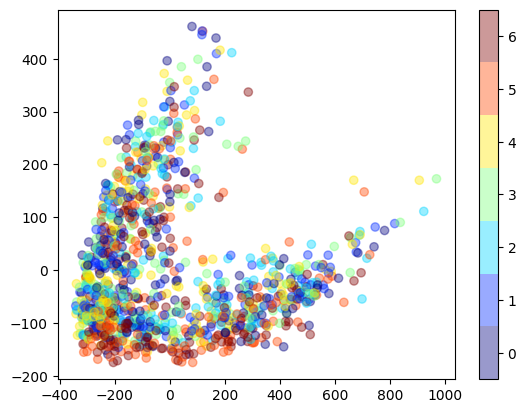

In [236]:
day_of_week = pivoted_load_data.index.day_of_week
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=day_of_week,
            cmap=plt.cm.get_cmap('jet', 7), alpha=0.4)
cb = plt.colorbar(ticks=range(7))
cb.set_ticklabels(['Mon', 'Tues', 'Wed', 'Thurs', 'Fri', 'Sat', 'Sun'])
plt.clim(-0.5, 6.5);

mid-year cluster 0:  summer months : 
    - demand: colling during the mid-day period
    - typically no need for morning cooling
January/December are cluster 1: winter months
    - demand: warming in the morning | warming in the evenings


So without any initial assumption, we have noticed two major daily patterns and then discovered how those represent summer and winter electricity usage patterns when we overlay the months on the principal co-efficients. While there are some similarities in both seasons, there are notable differences. In the summer months there is a simgle peak which occurs in the evening around 6 pm while here are two peaks in the winter months; one in the morning aroun 8am and the other around 8pm.

TO understand this summer winter patterns,, it may be worth considering the nature of electricity use in those tmes. In the summer months, there is often ned for cooling which in the relatively warmer afternoons, which explains the rise from morning till the early evening where the need for cooling is reduced. In the winter months however, heating would be needed in the mornings and evenings when it is cool and least required in the afternoon where the temperature is typically highest.

THis analysis also underscore the strong influence of temperature/weather on energy usage. North Carolina is located well North of the eqautor with significiant temperature swings.  It is possible to imaging that areas closer to the equator where temperatures are more stable year round do not hvae as strong correlation with temperature.

## Demand by Time

### Month

<Axes: xlabel='month', ylabel='load'>

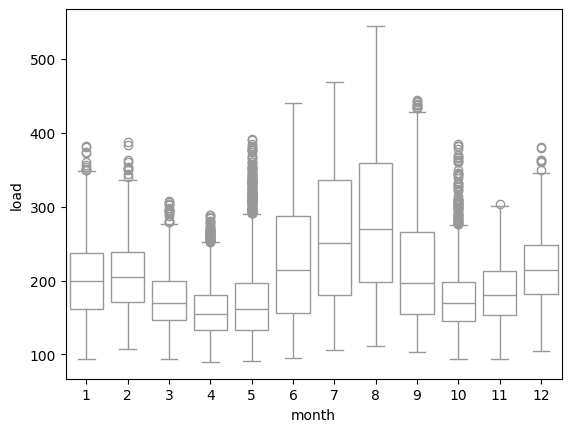

In [249]:
temp_df = (raw_load_data.copy()
           .assign(month = raw_load_data.datetime.dt.month)
           )

sns.boxplot(x='month', y='load', data=temp_df, color='w')

### Day of the week

<Axes: xlabel='day_of_wk', ylabel='load'>

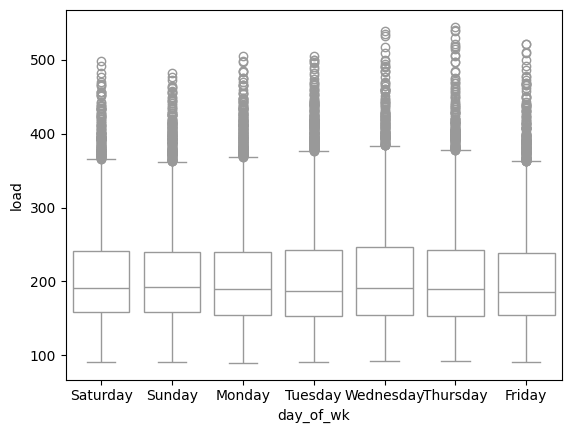

In [250]:
temp_df = (raw_load_data.copy()
           .assign(day_of_wk = raw_load_data.datetime.dt.day_name())
           )


sns.boxplot(x='day_of_wk', y='load', data=temp_df, color='w')

### hour of the day

<Axes: xlabel='hr', ylabel='load'>

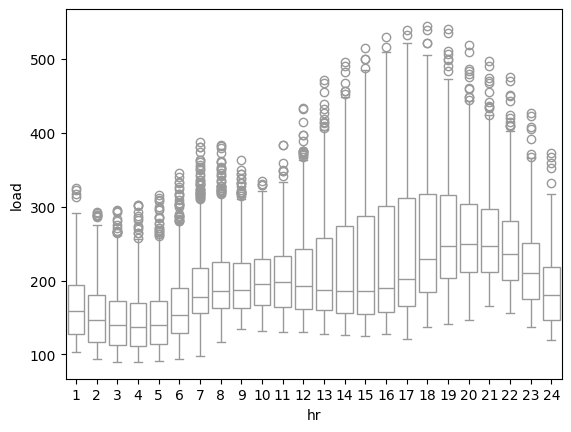

In [251]:
sns.boxplot(x='hr', y='load', data=raw_load_data, color='w');

## weekend hours

<Axes: xlabel='hr', ylabel='load'>

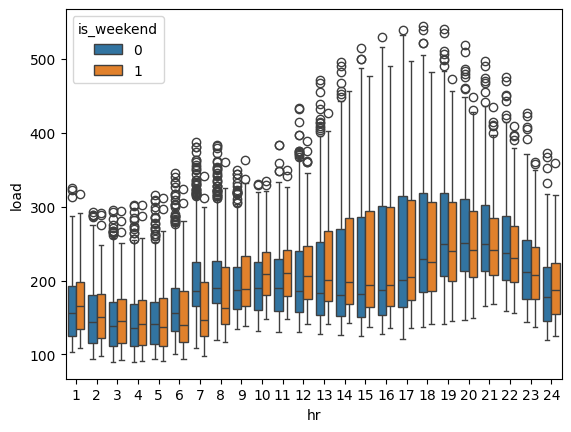

In [254]:
temp_df = (raw_load_data.copy()
           .assign(is_weekend = np.uint8(raw_load_data.datetime.dt.day_of_week > 4))
        #    .query('is_weekend==1')
        )


sns.boxplot(x='hr', y='load', data=temp_df, hue='is_weekend')

Weekends tends to be times when we wake up late and stay home for much longer in the day. From the graph, usage is lower between 6 and 8 am during the weekend which may be attributed to waking relatively later than in weekedays. however, as time passes into the day this reverses with increase usages in the weekend which may be due to families being awake and at home

We have seen that electricity demand is heavily dependent on time including time of day,  month, through waht looks like a combination of the daily activity pattern and climate/weather needs. 

Not much variation in overall demand for different days of the work week. There are some slight variations in usage patterns between weekend and weekdays that follow from intuition. 

## Temperature Data

In [268]:
raw_temp_data.head()

raw_temp_data = raw_temp_data[raw_temp_data.date < '2008']
raw_temp_data['datetime'] = raw_temp_data.date + pd.to_timedelta(raw_temp_data.hr, unit='h')  
print(raw_temp_data.head(3)), 
print(raw_temp_data.shape)

        date  hr  station_id  temperature            datetime
0 2005-01-01   1           1           43 2005-01-01 01:00:00
1 2005-01-01   2           1           41 2005-01-01 02:00:00
2 2005-01-01   3           1           40 2005-01-01 03:00:00
(735840, 5)


In [269]:
print(raw_load_data.shape[0])

26280


In [270]:
n_of_unique_stations = raw_temp_data.station_id.nunique()

n_temp_hours = raw_temp_data.shape[0] / n_of_unique_stations
print(n_temp_hours)
print(f"There are {n_of_unique_stations} unique stations")

26280.0
There are 28 unique stations


In [272]:
print(raw_temp_data.date.value_counts() / n_of_unique_stations)

date
2007-11-04    25.0
2005-10-30    25.0
2006-10-29    25.0
2005-01-01    24.0
2006-12-30    24.0
              ... 
2006-01-10    24.0
2007-12-31    24.0
2007-03-11    23.0
2006-04-02    23.0
2005-04-03    23.0
Name: count, Length: 1095, dtype: float64


m, similarly there is the daylight svaing time problem.

### preprocessing

In [284]:
temp_data = (raw_temp_data.copy()
             .query("date < '2008'")
             .assign(dummy_col=np.arange(len(raw_temp_data)) % 2)  # to preserve the repeated hours during pivot
             .pivot_table( values='temperature', index=['date', 'hr','datetime', 'dummy_col'], columns='station_id')
             )
#print(temp_data.head(2))

temp_data = (temp_data
             .reset_index()
             .drop(labels=['dummy_col', 'date', 'hr'], axis=1)
             .pipe(lambda d: d.rename(columns=dict([( col, 't'+str(col)) for col in d.columns if isinstance(col, int)])))
             )
temp_data_pivot = temp_data.copy()
print(temp_data_pivot.head(2))

station_id            datetime    t1    t2    t3    t4    t5    t6    t7  \
0          2005-01-01 01:00:00  43.0  46.0  40.0  47.0  48.0  46.0  44.0   
1          2005-01-01 02:00:00  41.0  46.0  38.0  46.0  48.0  45.0  51.0   

station_id    t8    t9  ...   t19   t20   t21   t22   t23   t24   t25   t26  \
0           52.0  45.0  ...  39.0  50.0  43.0  45.0  50.0  47.0  41.0  47.0   
1           50.0  42.0  ...  41.0  49.0  43.0  46.0  47.0  47.0  45.0  47.0   

station_id   t27   t28  
0           47.0  45.0  
1           47.0  45.0  

[2 rows x 29 columns]


In [313]:
temp_data_pivot.columns

Index(['datetime', 't1', 't2', 't3', 't4', 't5', 't6', 't7', 't8', 't9', 't10',
       't11', 't12', 't13', 't14', 't15', 't16', 't17', 't18', 't19', 't20',
       't21', 't22', 't23', 't24', 't25', 't26', 't27', 't28'],
      dtype='object', name='station_id')

### Exploratory Analysis

Text(0, 0.5, 'Temperature, $^\\circ$F')

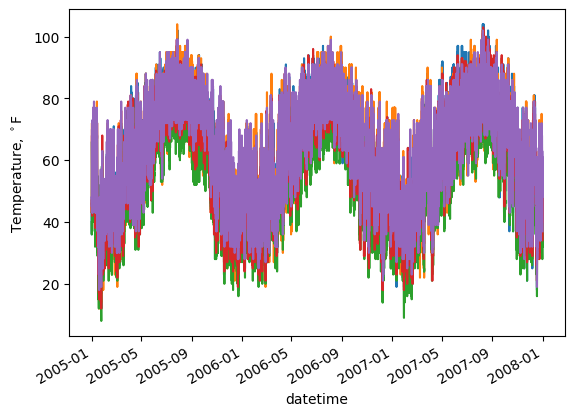

In [287]:
fig, ax = plt.subplots()
temp_data_pivot.set_index('datetime').iloc[:, :5].plot(legend=False, ax=ax)

ax.set_ylabel("Temperature, $^\circ$F")

We see the periodic annual pattern which was already implied by the preiovious analysis

#### Load and Temp

/tmp/ipykernel_26600/1840998436.py:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap=plt.cm.get_cmap('jet', 12), alpha=0.4, s=6)


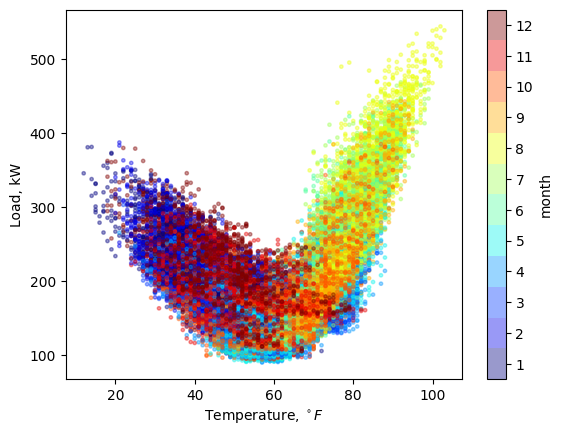

In [311]:
temp_df = (raw_load_data.copy()
           .assign(temp = temp_data_pivot.iloc[:, 4])
           .assign(month = raw_load_data.datetime.dt.month)
           )

# sns.scatterplot(x='temp', y='load', data=temp_df, alpha=0.2, size=0.2, hue='month')

month_of_year = raw_load_data.datetime.dt.month
plt.scatter(x=temp_df.temp, y=raw_load_data.load, c=month_of_year,
            cmap=plt.cm.get_cmap('jet', 12), alpha=0.4, s=6)
cb = plt.colorbar(ticks=range(1,12+1), label='month')
# cb.set_ticklabels(['Mon', 'Tues', 'Wed', 'Thurs', 'Fri', 'Sat', 'Sun'])
plt.xlabel('Temperature, $^\circ F$')
plt.ylabel('Load, kW')
plt.clim(0.5, 12.5);

The plot follows some of our preveious finding on the Temperature and load demand. Particularly notable heaere is that cooling demand during high tempretaures in August is largely responsible for the peak loads

#### Temperature Lags

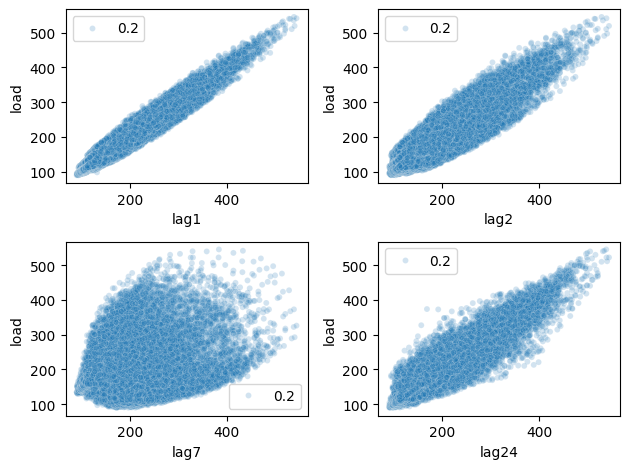

In [312]:
temp_df = (
    raw_load_data.copy()
    .assign(lag1=raw_load_data.load.shift(1))
    .assign(lag2=raw_load_data.load.shift(2))
    .assign(lag7=raw_load_data.load.shift(7))
    .assign(lag24=raw_load_data.load.shift(24))
)
fig, axs = plt.subplots(2, 2)
sns.scatterplot(x="lag1", y="load", data=temp_df, alpha=0.2, size=0.2, ax=axs[0, 0])
sns.scatterplot(x="lag2", y="load", data=temp_df, alpha=0.2, size=0.2, ax=axs[0, 1])
sns.scatterplot(x="lag7", y="load", data=temp_df, alpha=0.2, size=0.2, ax=axs[1, 0])
sns.scatterplot(
    x="lag24", y="load", data=temp_df, alpha=0.2, size=0.2, ax=axs[1, 1]
)
# set_plot_labels(axs, xlabel="temp")
fig.tight_layout()

### subset temp columns
We have to determine a strategy for selecting the optimal temperature stations considering there are quite a number of them

features:
- historical load and temp dataframe
- inference input:
    - date
    - temperature (28 stations)
- engineering:
    - trend
    - date comp:
        - h, d, m, is_holiday, season_func
    - lags:
        - temp 1, 2
        - load 1, 2
    - temp
        - one at a time and get score
            - 1,2,3 order,
            - interaction: TM, Mt2, Mt3, HT, Ht2, Ht3
        - get subset
-       - 

        


In [ ]:
from 

In [297]:
temp_col_names = list(temp_data_pivot.columns[1:])


array([[43., 41., 40., ..., 39., 36., 44.],
       [46., 46., 46., ..., 36., 37., 37.],
       [40., 38., 37., ..., 34., 32., 32.],
       ...,
       [47., 47., 46., ..., 40., 47., 39.],
       [47., 47., 46., ..., 45., 45., 45.],
       [45., 45., 43., ..., 35., 42., 37.]])

(28, 26280)


AttributeError: 'numpy.ndarray' object has no attribute '_validate_params'

In [132]:
print(temp_data_pivot.shape)
print(temp_data_pivot.datetime.value_counts())

(26280, 29)
datetime
2006-10-29 02:00:00    2
2007-11-04 02:00:00    2
2005-10-30 02:00:00    2
2005-01-01 01:00:00    1
2006-12-31 21:00:00    1
                      ..
2005-12-31 23:00:00    1
2005-12-31 22:00:00    1
2005-12-31 21:00:00    1
2005-12-31 20:00:00    1
2008-01-01 00:00:00    1
Name: count, Length: 26277, dtype: int64
